# NEMA Photoelectric

- Photoelectric interaction in PETALO

In [1]:
import Pkg

In [2]:
Pkg.add.(["HTTP", "Plots", "DataFrames", "HDF5","DrWatson", "StatsBase", "PhysicalConstants"]);

In [3]:
Pkg.add.(["Test"]);

In [4]:
Pkg.add.(["VegaLite","VegaDatasets"]);

In [5]:
Pkg.add.(["LsqFit","GLM"])

2-element Vector{Nothing}:
 nothing
 nothing

In [861]:
Pkg.add("Distributions") 

In [1]:
using Distributions

In [2]:
using LsqFit
using GLM

In [3]:
using HTTP
using Plots
using VegaLite
using VegaDatasets
using DataFrames
using HDF5
using DrWatson
using Test
using PhysicalConstants
using PhysicalConstants.CODATA2018
using Unitful

In [4]:
using Glob
using CSV

In [5]:
using Statistics
using StatsBase
using Printf

In [6]:
using Logging

In [7]:
@quickactivate "JPetalo"

In [8]:
pwd()

"/Users/jj/JuliaProjects/JPetalo/notebooks"

In [9]:
datadir()

"/Users/jj/JuliaProjects/JPetalo/data"

In [10]:
srcdir()

"/Users/jj/JuliaProjects/JPetalo/src"

In [11]:
include(srcdir("jpetalo.jl"))

Main.JPetalo

In [12]:
import Unitful:
    nm, μm, mm, cm, m, km, inch, ft, mi,
    ac,
    mg, g, kg,
    Ra, °F, °C, K,
    rad, °,
    ns, μs, ms, ps, s, minute, hr, d, yr, Hz,
    eV,
    μJ, mJ, J,
	mW, μW, W,
    A, N, mol, mmol, V, L, mL, μL, M

In [13]:
function loglevel(log)
    if log == "Debug"
        logger = SimpleLogger(stdout, Logging.Debug)
    elseif log =="Info"
        logger = SimpleLogger(stdout, Logging.Info)
    else
        logger = SimpleLogger(stdout, Logging.Warn)
    end
    old_logger = global_logger(logger)
end

loglevel (generic function with 1 method)

# Characterization of PETALO

In [14]:
loglevel("Info")

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(44) open, 0 bytes waiting))), Info, Dict{Any, Int64}())

### Read a summary data frame with photoelectric interactions

In [255]:
drx = datadir("nema3df")
input = string(drx,"/nemadf_f500_detconf_pde_03_sigmatof_85ps_kmeans_phot.csv")
n3df = DataFrame(CSV.File(input));

In [256]:
println(names(n3df))

["nsipm1", "nsipm2", "q1", "q2", "r1", "r1q", "r2", "r2q", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zt1", "zt2"]


## Dependence of energy with radius of interaction
- Histograming the energy deposited in the SiPMs yields a wide and non gaussian distribution
- The reason is that the energy deposited in the SiPMs depends of the radius at which the gamms interacted.
- The relation is roughly linear in a good range of radius, cannot be used for charge too low and saturates for charge too high
- This dependence can be used to define an estimator, "rq" of the radius of interaction

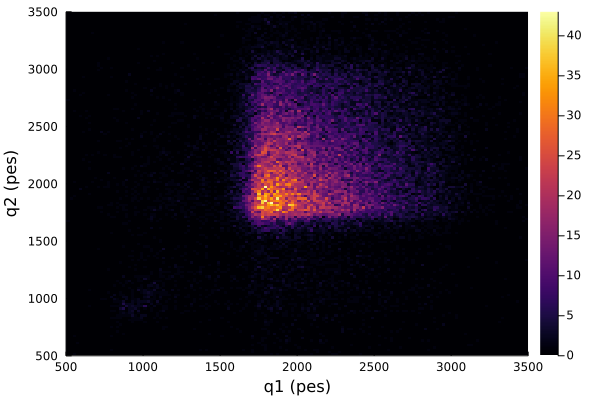

In [257]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3df.q1,n3df.q2, 150, "q1 (pes)", "q2 (pes)", 0., 10000., 0., 10000.)
plot(phqr, legend=false, fmt = :png)

In [258]:
n3q1 = JPetalo.select_by_column_value_gt(n3df, "q1", 1800.0)
n3q  = JPetalo.select_by_column_value_gt(n3q1, "q2", 1800.0);

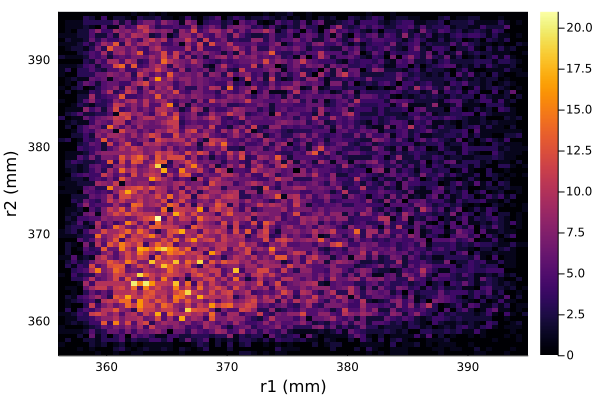

In [259]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3q.r1,n3q.r2, 150, "r1 (mm)", "r2 (mm)", 350., 400., 350., 400.)
plot(phqr, legend=false, fmt = :png)

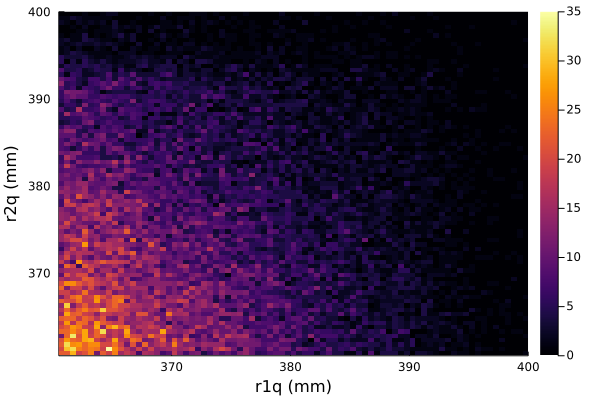

In [260]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3q.r1q,n3q.r2q, 150, "r1q (mm)", "r2q (mm)", 300., 400., 300., 400.)
plot(phqr, legend=false, fmt = :png)

### R resolution

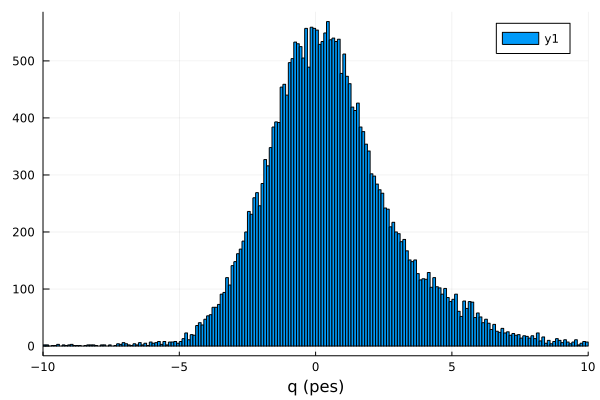

In [264]:
hqc = JPetalo.hist1d(n3q.r1 - n3q.r1q, 200, -10., 10.)
phqc = plot(hqc, xlim=(-10., 10.), xlabel="q (pes)")

In [265]:
g1p = (xmin= 2.0, xmax= 7.0, nbin=100)
g2p = (xmin= -2.0, xmax=  2.0, nbin=100)
gp  = (xmin= -5.0, xmax=  7.0, nbin=200)
fg = JPetalo.fit_2gauss_cmean(n3q.r1 - n3q.r1q, gp, g1p, g2p, 0.0)
@info "sigma" fg.sigma1 fg.sigma2

┌ Info: sigma
│   fg.sigma1 = 6.352801680276235
│   fg.sigma2 = 1.7021359147168988
└ @ Main In[265]:5


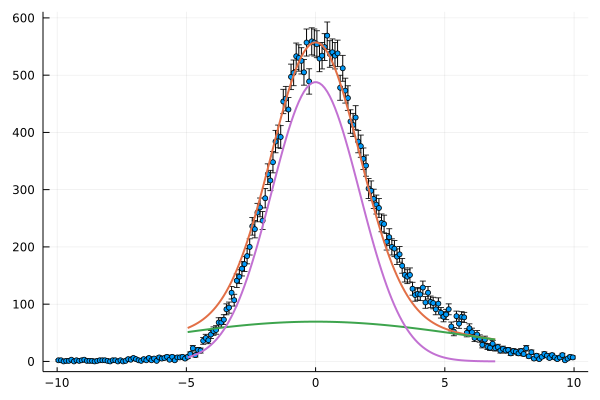

In [266]:
yg = hqc.weights
xg = JPetalo.centers(hqc)
psqc = scatter(xg,yg, yerr = sqrt.(yg), markersize=3, legend=false)
p = plot!(psqc,fg.xg, fg.yg, lw=2)
p = plot!(p,fg.xg, fg.gx1.(fg.xg), lw=2)
p = plot!(p,fg.xg, fg.gx2.(fg.xg), lw=2)

### Q vs R

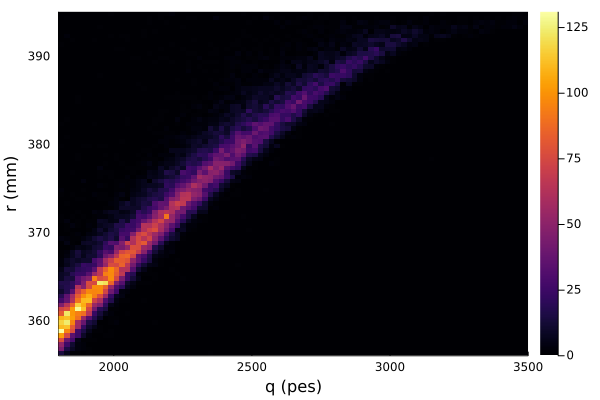

In [267]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3q.q1,n3q.r1, 150, "q (pes)", "r (mm)")
plot(phqr, legend=false, fmt = :png)

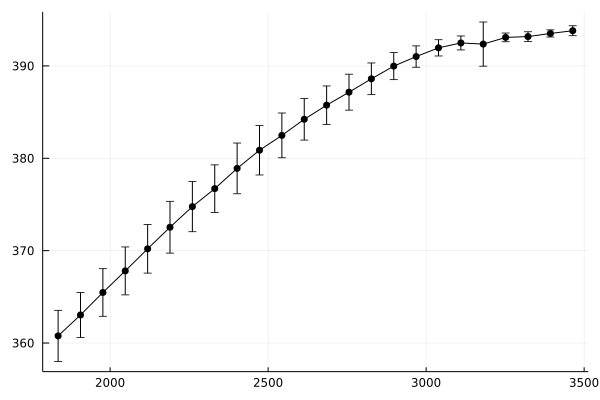

In [268]:
pqrdf = JPetalo.p1df(n3q.q1, n3q.r1, 25)
pp = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)

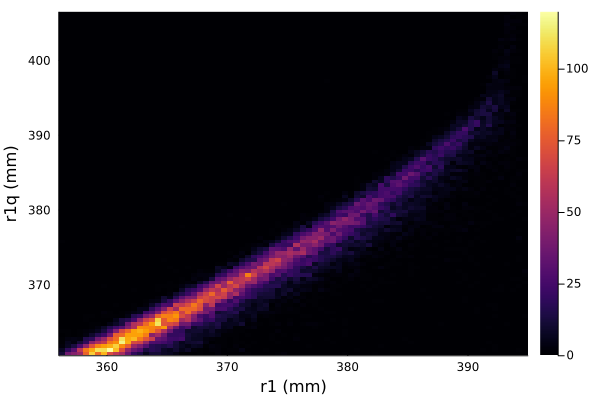

In [269]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3q.r1,n3q.r1q, 150, "r1 (mm)", "r1q (mm)")
plot(phqr, legend=false, fmt = :png)

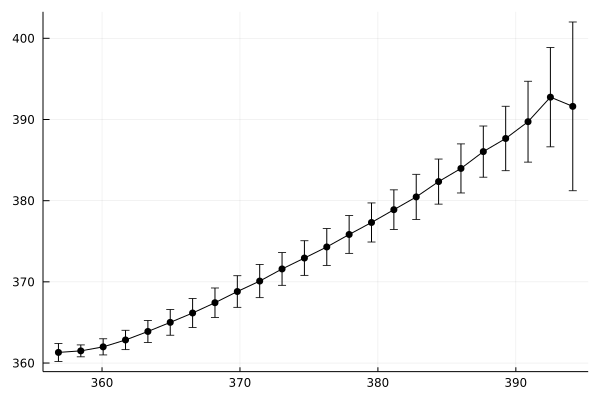

In [270]:
pqrdf = JPetalo.p1df(n3q.r1, n3q.r1q, 25)
pp = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)

### Number of SiPMs with charge above threshold

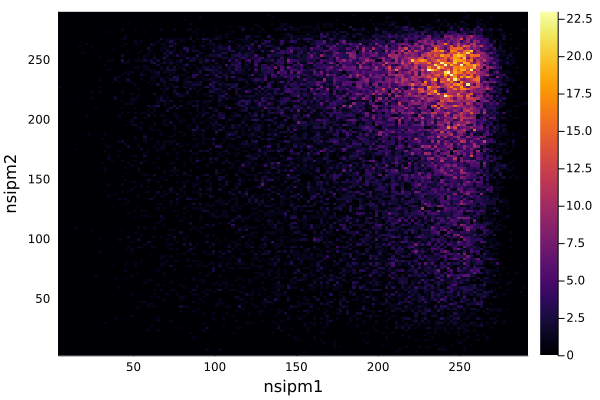

In [271]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3q.nsipm1*1.,n3q.nsipm2*1., 150, "nsipm1", "nsipm2")
plot(phqr, legend=false, fmt = :png)

## Resolution in (x,y,z,r) intrinsic

In [277]:
limxy = 5.0;

In [278]:
hxtxr, pxtxr = JPetalo.hist1d(n3q.xt1 - n3q.x1, "xt - xr", 50,  -limxy, limxy);
plot(pxtxr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);

In [279]:
hytyr, pytyr = JPetalo.hist1d(n3q.yt1 - n3q.y1, "yt - yr", 50,  -limxy, limxy);
plot(pytyr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);

In [280]:
hztzr, pztzr = JPetalo.hist1d(n3q.zt1 - n3q.z1, "zt - zr", 50,  -limxy, limxy);
plot(pztzr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);

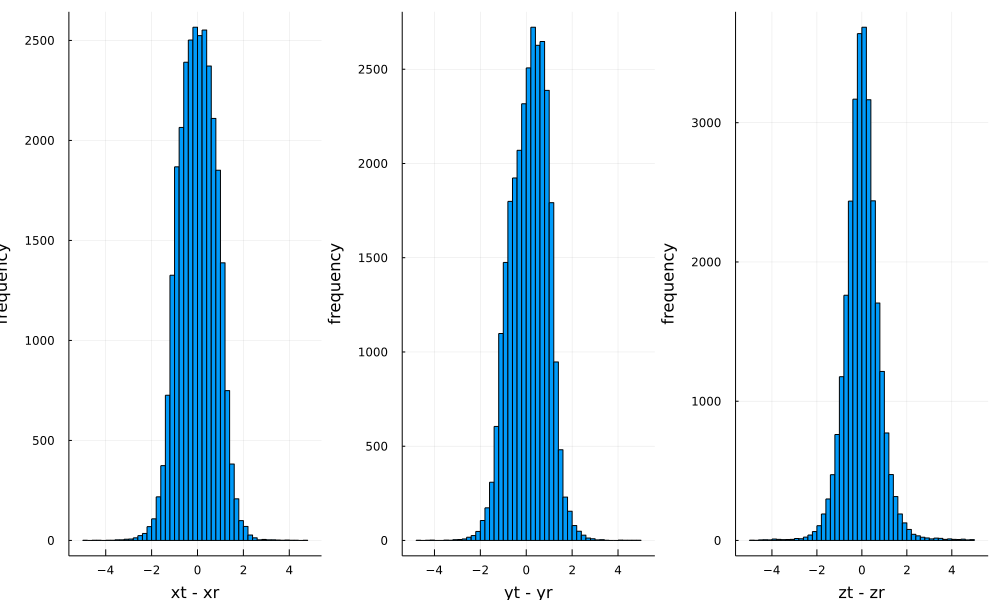

In [281]:
plot(pxtxr, pytyr,pztzr, layout = (1, 3), size = (1000, 600), 
     legend=false, fmt = :png)

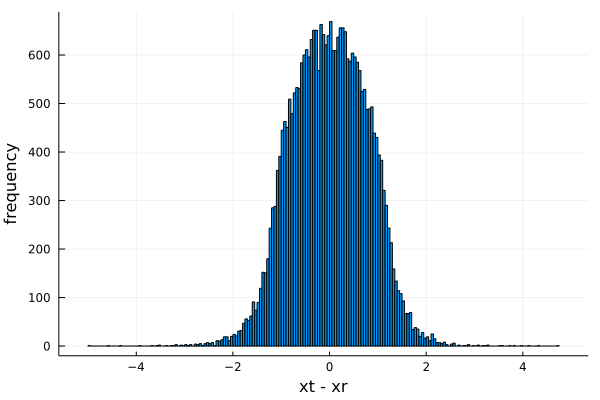

In [282]:
hxtxr, pxtxr = JPetalo.hist1d(n3q.xt1 - n3q.x1, "xt - xr", 200,  -limxy, limxy);
plot(pxtxr,  layout = (1, 1),  
     legend=false, fmt = :png)

In [289]:
fg = JPetalo.gfit_xgauss(n3q.xt1 - n3q.x1, -2.0, 2.0, 100)
@info "sigma" fg.sigma

┌ Info: sigma
│   fg.sigma = 0.8502672798647095
└ @ Main In[289]:2


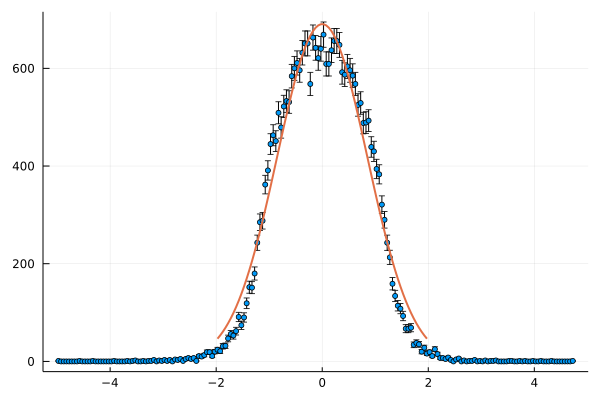

In [290]:
yg = hxtxr.weights
xg = JPetalo.centers(hxtxr)
psqc = scatter(xg,yg, yerr = sqrt.(yg), markersize=3, legend=false)
p = plot!(psqc,fg.xg, fg.yg, lw=2)

In [291]:
@info "resolution (mm): sigma = $(fg.sigma)  FWHM = $(2.3 *fg.sigma) "

┌ Info: resolution (mm): sigma = 0.8502672798647095  FWHM = 1.9556147436888318 
└ @ Main In[291]:1


## Resolution in xyz (r from q)

In [294]:
limxy = 10.0;

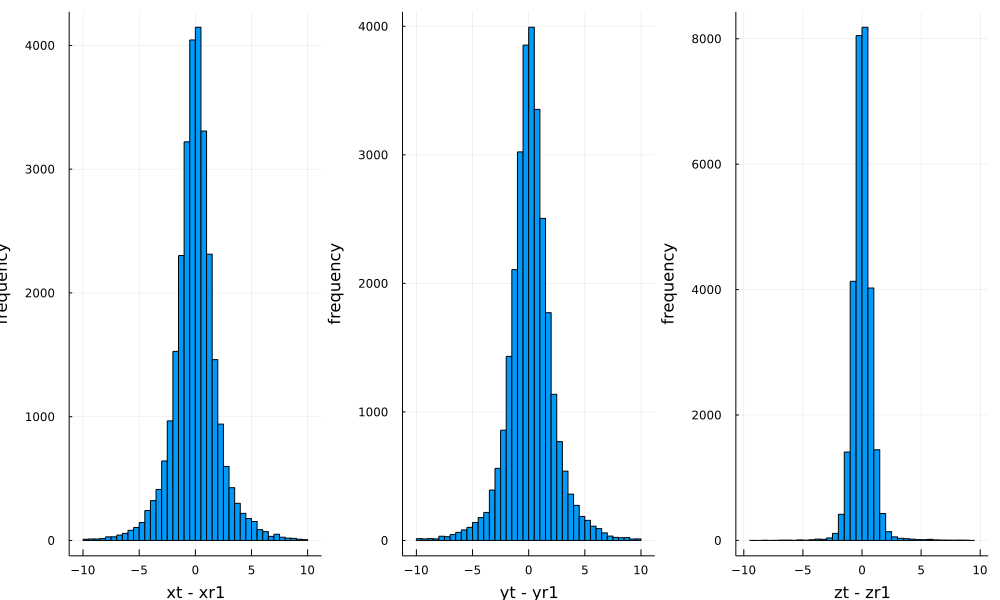

In [295]:
hxtxr, pxtxr = JPetalo.hist1d(n3q.xt1 - n3q.xr1, "xt - xr1", 50,  -limxy, limxy);
plot(pxtxr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
hytyr, pytyr = JPetalo.hist1d(n3q.yt1 - n3q.yr1, "yt - yr1", 50,  -limxy, limxy);
plot(pytyr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
hztzr, pztzr = JPetalo.hist1d(n3q.zt1 - n3q.zr1, "zt - zr1", 50,  -limxy, limxy);
plot(pztzr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);
plot(pxtxr, pytyr,pztzr, layout = (1, 3), size = (1000, 600), 
     legend=false, fmt = :png)

In [299]:
g1p = (xmin= -10.0, xmax= -1.0, nbin=100)
g2p = (xmin= -1.0, xmax=  1.0, nbin=100)
gp  = (xmin= -10.0, xmax=  10.0, nbin=200)
fg = JPetalo.fit_2gauss_cmean(n3q.xt1 - n3q.xr1, gp, g1p, g2p, 0.0)
@info "sigma" fg.sigma1 fg.sigma2

┌ Info: sigma
│   fg.sigma1 = 2.4409284743411863
│   fg.sigma2 = 0.9735132876386584
└ @ Main In[299]:5


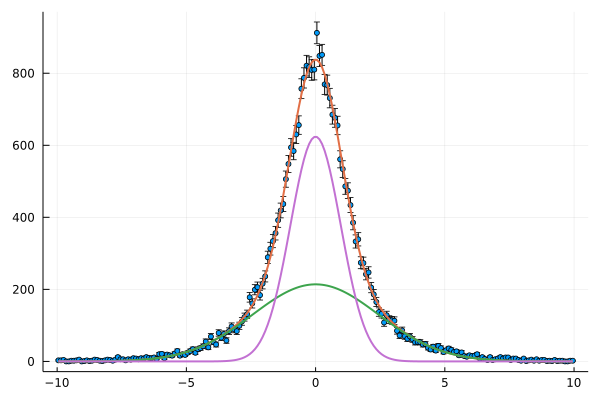

In [300]:
hxtxr, pxtxr = JPetalo.hist1d(n3q.xt1 - n3q.xr1, "xt - xr1", 200,  -limxy, limxy)
yg = hxtxr.weights
xg = JPetalo.centers(hxtxr)
psqc = scatter(xg,yg, yerr = sqrt.(yg), markersize=3, legend=false)
p = plot!(psqc,fg.xg, fg.yg, lw=2)
p = plot!(p,fg.xg, fg.gx1.(fg.xg), lw=2)
p = plot!(p,fg.xg, fg.gx2.(fg.xg), lw=2)

In [301]:
@info "resolution (mm): sigma = $(fg.sigma2)  FWHM = $(2.3 *fg.sigma2) "

┌ Info: resolution (mm): sigma = 0.9735132876386584  FWHM = 2.239080561568914 
└ @ Main In[301]:1


## TOF

In [302]:
c0 =uconvert(mm/ns, float(SpeedOfLightInVacuum))

299.792458 mm ns⁻¹

In [303]:
cc = convert(Float32, c0/(mm*ns^-1))

299.79245f0

In [304]:
function ct12(df, t="nominal")
    if t == "minimum"
        return 1000.0*(df.tr1 - df.tr2)
    elseif t == "average"
        return 1000.0*(df.ta1 - df.ta2)
    else
        return 1000.0 * (df.t1 - df.t2)
    end
end
        


ct12 (generic function with 2 methods)

In [305]:
function ctsr(df, reco=true)
    if reco
        tsr1 = [JPetalo.dxyz([df.xr1[i], df.yr1[i], df.zr1[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
        tsr2 = [JPetalo.dxyz([df.xr2[i], df.yr2[i], df.zr2[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
        
    else
        tsr1 = [JPetalo.dxyz([df.x1[i], df.y1[i], df.z1[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
        tsr2 = [JPetalo.dxyz([df.x2[i], df.y2[i], df.z2[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
    end
    return 1000.0*(tsr1 - tsr2)
end

ctsr (generic function with 2 methods)

In [306]:
function crb(df, reco=true)
    clxe = cc/1.6
    if reco
        trb1 = [JPetalo.dxyz([df.xr1[i], df.yr1[i], df.zr1[i]], 
                             [df.xb1[i], df.yb1[i], df.zb1[i]]) for i in 1:nrow(df)]/clxe;
        trb2 = [JPetalo.dxyz([df.xr2[i], df.yr2[i], df.zr2[i]], 
                             [df.xb2[i], df.yb2[i], df.zb2[i]]) for i in 1:nrow(df)]/clxe;
        
    else
        trb1 = [JPetalo.dxyz([df.x1[i], df.y1[i], df.z1[i]], 
                             [df.xb1[i], df.yb1[i], df.zb1[i]]) for i in 1:nrow(df)]/clxe;
        trb2 = [JPetalo.dxyz([df.x2[i], df.y2[i], df.z2[i]], 
                             [df.xb2[i], df.yb2[i], df.zb2[i]]) for i in 1:nrow(df)]/clxe;
     end
    return 1000.0*(trb1 - trb2)
end

crb (generic function with 2 methods)

In [307]:
t12 = ct12(n3q, "nominal");

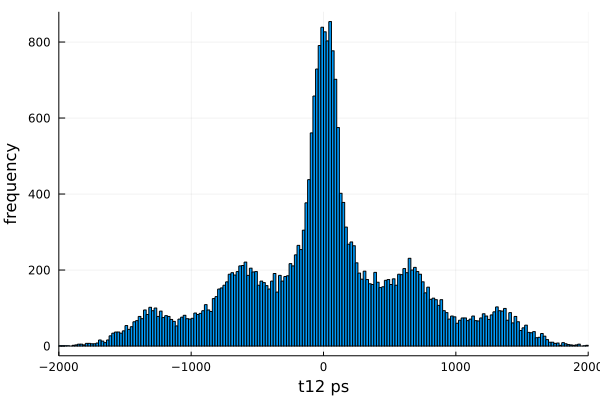

In [308]:
ht1t2, pt1t2 = JPetalo.hist1d(t12, "t12 ps", 200,  -2000., 2000.)
plot(pt1t2, xlimit=(-2000.0,2000.0), legend=false)

In [309]:
g1p = (xmin= -2000.0, xmax= -200.0, nbin=100)
g2p = (xmin= -200.0, xmax=  200.0, nbin=100)
gp  = (xmin= -2000.0, xmax=  2000.0, nbin=200)
fg = JPetalo.fit_2gauss_cmean(t12, gp, g1p, g2p, 0.0)
@info "sigma" fg.sigma1 fg.sigma2

┌ Info: sigma
│   fg.sigma1 = 836.3211985304882
│   fg.sigma2 = 87.45721025331136
└ @ Main In[309]:5


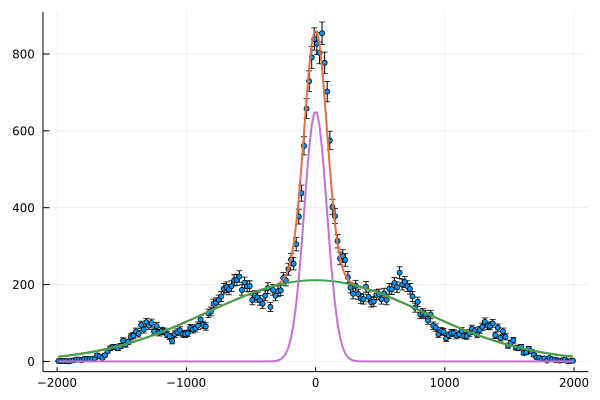

In [310]:
yg = ht1t2.weights
xg = JPetalo.centers(ht1t2)
psqc = scatter(xg,yg, yerr = sqrt.(yg), markersize=3, legend=false)
p = plot!(psqc,fg.xg, fg.yg, lw=2)
p = plot!(p,fg.xg, fg.gx1.(fg.xg), lw=2)
p = plot!(p,fg.xg, fg.gx2.(fg.xg), lw=2)

In [311]:
tsr12 = ctsr(n3q, false);

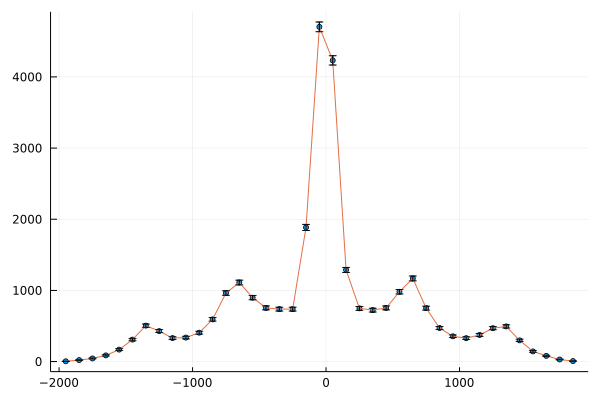

In [312]:
htsr12, psr1t2 = JPetalo.hist1d(tsr12, "tsr12 ps", 50,  -2000., 2000.)
yg = htsr12.weights
xg = JPetalo.centers(htsr12)
psqc = scatter(xg,yg, yerr = sqrt.(yg), markersize=3, legend=false)
psqc = plot!(psqc, xg,yg, yerr = sqrt.(yg), linewidth=1, legend=false)

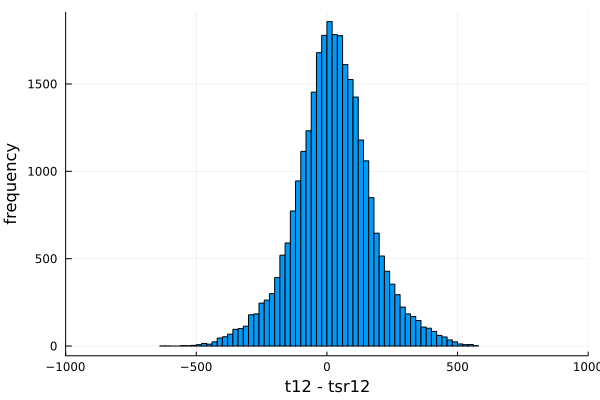

In [313]:
h12, p12 = JPetalo.hist1d(t12-tsr12, "t12 - tsr12", 100,  -1000., 1000.)
plot(p12, xlimit=(-1000.0,1000.0),legend=false) 

In [314]:
trb12 = crb(n3q, false);

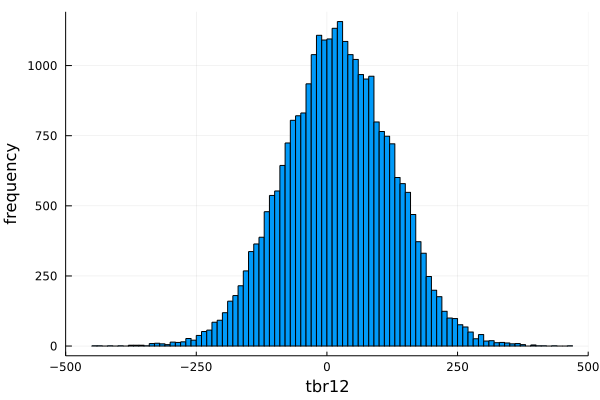

In [315]:
htrb12, ptrb12 = JPetalo.hist1d(trb12, "tbr12", 100,  -500., 500.)
plot(ptrb12, xlimit=(-500.0,500.0), legend=false) 

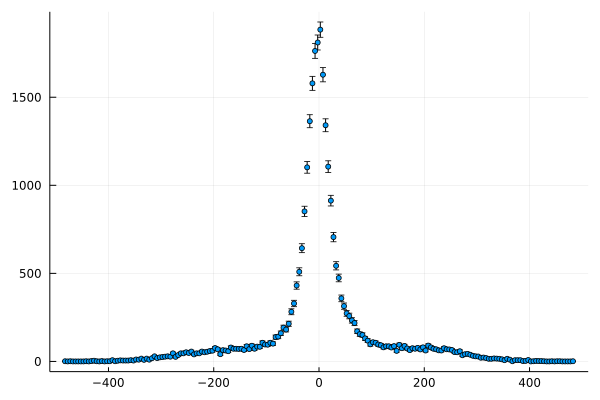

In [316]:
h12, p12 = JPetalo.hist1d(t12 - tsr12 - trb12  , "t12 - tsr12 - trb12", 200,  -500., 500.)
yg = h12.weights
xg = JPetalo.centers(h12)
psqc = scatter(xg,yg, yerr = sqrt.(yg), markersize=3, legend=false)

In [317]:
dt = t12 - tsr12 - trb12;

In [318]:
g1p = (xmin= -500.0, xmax= -50.0, nbin=100)
g2p = (xmin= -50.0, xmax=  50.0, nbin=100)
gp  = (xmin= -500.0, xmax=  500.0, nbin=200)
fg = JPetalo.fit_2gauss_cmean(dt, gp, g1p, g2p, 0.0)
@info "sigma" fg.sigma1 fg.sigma2

┌ Info: sigma
│   fg.sigma1 = 141.52937715975082
│   fg.sigma2 = 20.27262342917089
└ @ Main In[318]:5


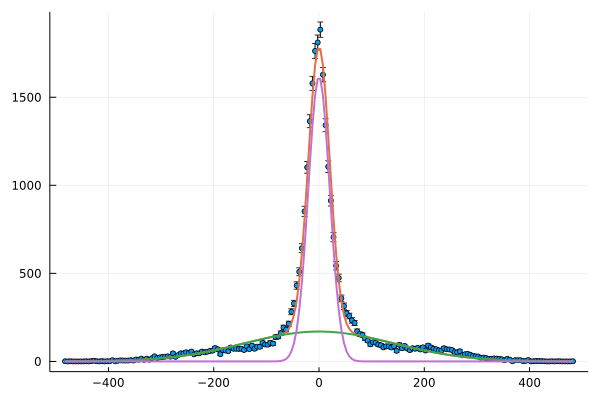

In [321]:
psqc = scatter(xg,yg, yerr = sqrt.(yg), markersize=3, legend=false)
p = plot!(psqc,fg.xg, fg.yg, lw=2)
p = plot!(p,fg.xg, fg.gx1.(fg.xg), lw=2)
p = plot!(p,fg.xg, fg.gx2.(fg.xg), lw=2)

In [322]:
@info "FWHM: crt1 = $(2.3 * fg.sigma1) crt2 = $(2.3*fg.sigma2)" 

┌ Info: FWHM: crt1 = 325.5175674674269 crt2 = 46.62703388709304
└ @ Main In[322]:1


In [323]:
function crt(df, t="nominal", reco1=false, reco2=false)
    t12 = ct12(df, t)
    g1p = (xmin= -2000.0, xmax= -200.0, nbin=50)
    g2p = (xmin= -200.0, xmax=  200.0, nbin=50)
    gp  = (xmin= -2000.0, xmax=  2000.0, nbin=100)
    ft12 = JPetalo.fit_2gauss_cmean(t12, gp, g1p, g2p, 0.0)
    @info "t12: sigma" ft12.sigma1 ft12.sigma2

    tsr12 = ctsr(df, reco1)
    trb12 = crb(df, reco2)
    dt = t12 - tsr12 - trb12
    
    g1p = (xmin= -500.0, xmax= -50.0, nbin=50)
    g2p = (xmin= -50.0, xmax=  50.0, nbin=50)
    gp  = (xmin= -500.0, xmax=  500.0, nbin=100)
    fdt = JPetalo.fit_2gauss_cmean(dt, gp, g1p, g2p, 0.0)
    @info "dt: sigma" fdt.sigma1 fdt.sigma2
    return t12, dt, ft12, fdt

end

crt (generic function with 5 methods)

In [324]:
function plotg2fit(fg, label, lw=2)
    yg = fg.h.weights
    xg = JPetalo.centers(fg.h)
    psqc = scatter(xg,yg, yerr = sqrt.(yg), markersize=3, xlabel=label, legend=false)
    #p = plot(fg.h, xlabel=label)
    p = plot!(psqc,fg.xg, fg.yg, lw=lw)
    p = plot!(p,fg.xg, fg.gx1.(fg.xg), lw=lw)
    p = plot!(p,fg.xg, fg.gx2.(fg.xg), lw=lw)
    return p
end

plotg2fit (generic function with 2 methods)

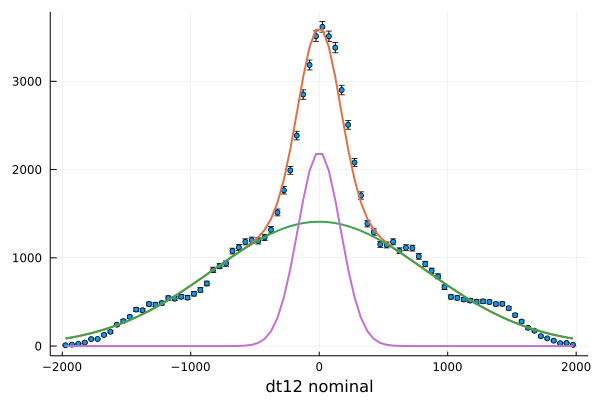

In [325]:
pdt12 = plotg2fit(ft12, "dt12 nominal")

In [326]:
dt12, dt, ft12, fdt  = crt(n3q, "nominal", false, false);

┌ Info: t12: sigma
│   ft12.sigma1 = 836.136822134945
│   ft12.sigma2 = 88.43733558208119
└ @ Main In[323]:7
┌ Info: dt: sigma
│   fdt.sigma1 = 142.50276272505832
│   fdt.sigma2 = 20.49895142087313
└ @ Main In[323]:17


In [327]:
pdt12 = plotg2fit(ft12, "dt12 nominal");

In [328]:
pdt = plotg2fit(fdt, "dt nominal");

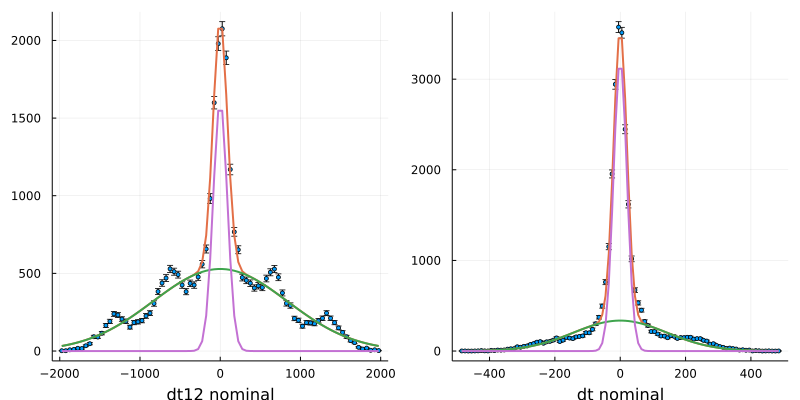

In [329]:
plot(pdt12, pdt, layout = (1, 2), size = (800, 400), 
     legend=false, fmt = :png) 

In [330]:
@info "FWHM: crt1 = $(2.3 * fdt.sigma1) crt2 = $(2.3*fdt.sigma2)" 

┌ Info: FWHM: crt1 = 327.7563542676341 crt2 = 47.14758826800819
└ @ Main In[330]:1


In [331]:
dt12, dt, ft12, fdt  = crt(n3q, "minimum", false, false);

┌ Info: t12: sigma
│   ft12.sigma1 = 815.3268443891739
│   ft12.sigma2 = 131.2273733553455
└ @ Main In[323]:7
┌ Info: dt: sigma
│   fdt.sigma1 = 96.20665948523337
│   fdt.sigma2 = 173.1621065286404
└ @ Main In[323]:17


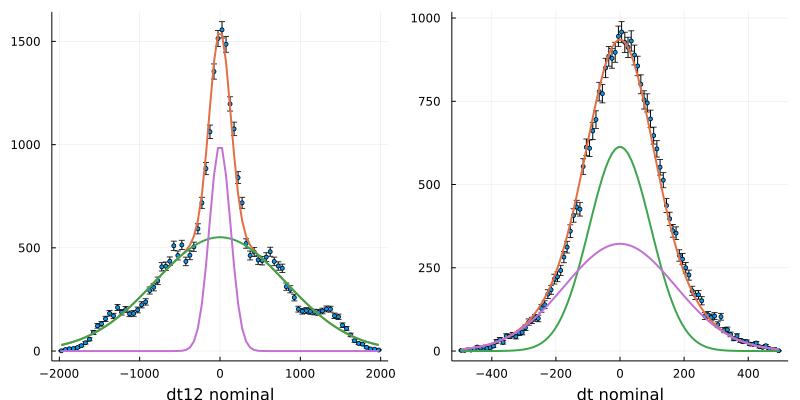

In [332]:
pdt12 = plotg2fit(ft12, "dt12 nominal");
pdt = plotg2fit(fdt, "dt nominal");
plot(pdt12, pdt, layout = (1, 2), size = (800, 400), 
     legend=false, fmt = :png) 

In [333]:
@info "FWHM: crt1 = $(2.3 * fdt.sigma1) crt2 = $(2.3*fdt.sigma2)" 

┌ Info: FWHM: crt1 = 221.27531681603674 crt2 = 398.2728450158729
└ @ Main In[333]:1


In [334]:
dt12, dt, ft12, fdt  = crt(n3q, "average", false, false);

┌ Info: t12: sigma
│   ft12.sigma1 = 827.7180516452772
│   ft12.sigma2 = 140.3225517179615
└ @ Main In[323]:7
┌ Info: dt: sigma
│   fdt.sigma1 = 86.08358465093407
│   fdt.sigma2 = 146.87626895445646
└ @ Main In[323]:17


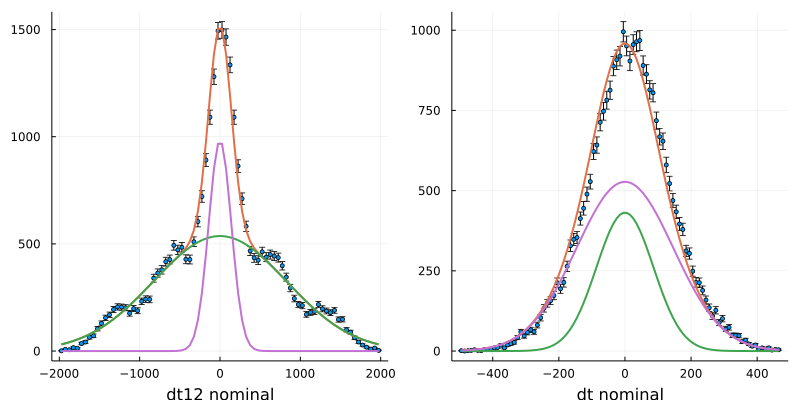

In [335]:
pdt12 = plotg2fit(ft12, "dt12 nominal");
pdt = plotg2fit(fdt, "dt nominal");
plot(pdt12, pdt, layout = (1, 2), size = (800, 400), 
     legend=false, fmt = :png) 

In [336]:
@info "FWHM: crt1 = $(2.3 * fdt.sigma1) crt2 = $(2.3*fdt.sigma2)" 

┌ Info: FWHM: crt1 = 197.99224469714835 crt2 = 337.81541859524987
└ @ Main In[336]:1
